# DeepSphere using ModelNet40 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721) and others spherical CNNs
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from ModelNet40.load_MN40 import plot_healpix_projection, ModelNet40DatasetTF, ModelNet40DatasetCache

## 0.2 Define parameters

In [4]:
Nside = 32
exp='norot' # in ['rot', 'norot', 'pert', 'Z']
datapath = '../data/ModelNet40/' # localisation of the .OFF files
proc_path = datapath[1:]

In [22]:
augmentation = 1        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

#### Test projection

In [205]:
import trimesh
mesh = trimesh.load_mesh(datapath+'airplane'+"/train/"+'airplane'+"_0119.off")
mesh.remove_degenerate_faces()
mesh.remove_duplicate_faces()
mesh.show()

In [22]:
from ModelNet40.load_MN40 import rotmat, rnd_rot

In [23]:
import trimesh
mesh = trimesh.load_mesh(datapath+'plant'+"/test/"+'plant'+"_0338.off")
mesh.remove_degenerate_faces()
mesh.fix_normals()
mesh.fill_holes()
mesh.remove_duplicate_faces()
mesh.remove_infinite_values()
mesh.remove_unreferenced_vertices()

mesh.apply_translation(-mesh.centroid)
r = np.max(np.linalg.norm(mesh.vertices, axis=-1))
mesh.apply_scale(1 / r)

mesh.apply_transform(rnd_rot(z=0, c=0))

r = np.max(np.linalg.norm(mesh.vertices, axis=-1))
mesh.apply_scale(0.99 / r)
mesh.remove_degenerate_faces()
mesh.fix_normals()
mesh.fill_holes()
mesh.remove_duplicate_faces()
mesh.remove_infinite_values()
mesh.remove_unreferenced_vertices()
mesh.show()


array([1.7408671 , 1.4599597 , 1.4379181 , ..., 0.17213222, 0.13229477,
       0.15436278], dtype=float32)

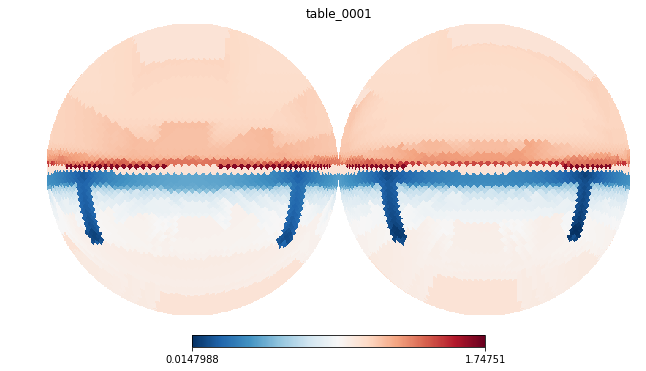

In [42]:
_class = 'table'
plot_healpix_projection(datapath+_class+"/train/"+_class+"_0001.off", 32, rotp = False, rot = (90,0,0))

array([0.503119  , 0.49012864, 0.51456213, ..., 0.51456213, 0.49012864,
       0.503119  ], dtype=float32)

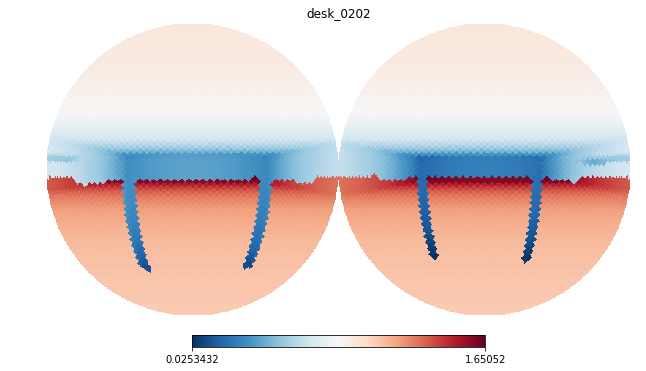

In [113]:
_class = 'desk'
plot_healpix_projection(datapath+_class+"/test/"+_class+"_0202.off", 32, rotp = False, rot = (90,0,0))

array([0.47457233, 0.47958493, 0.4687562 , ..., 0.93882203, 0.93753195,
       0.94020647], dtype=float32)

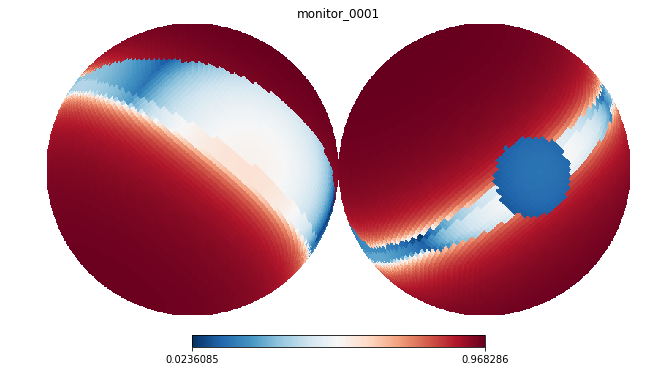

In [286]:
_class = 'monitor'
plot_healpix_projection(datapath+_class+"/train/"+_class+"_0001.off", 32, rotp = True, rot = (90,0,0))

array([0.88494617, 0.88560784, 0.884164  , ..., 0.8833286 , 0.8847804 ,
       0.88401675], dtype=float32)

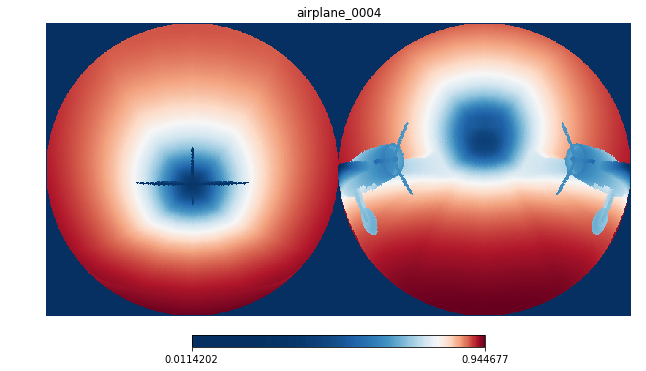

In [27]:
classes = ["airplane", "bathtub", "..."]
plot_healpix_projection(datapath+classes[0]+"/train/"+classes[0]+"_0004.off", 128, rotp = False, rot = (90,0,0))

## 1 Load dataset

In [23]:
train_rot_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                              experiment='deepsphere_rot_notr')


In [24]:
train_rot_tr_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                           experiment='deepsphere_rot')


In [25]:
train_tr_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                       experiment='deepsphere')


In [26]:
train_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None, 
                                          experiment='deepsphere_notr')


In [27]:
train_Z_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                         experiment='deepsphere_Z')


Better to keep validation and testing set in RAM, but not always possible

In [28]:
test_tr_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None)

In [29]:
test_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None,
                                        experiment='deepsphere_notr')

In [30]:
test_rot_tr_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot', augmentation=3, nfile=None)

In [31]:
test_rot_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot_notr', augmentation=3, nfile=None)

In [32]:
test_Z_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_Z', augmentation=3, nfile=None)

Try do make a tensorflow dataset object

In [16]:
experiment = 'deepsphere'+('_rot' if exp == 'rot' else '')+('_Z' if exp == 'Z' else '')+('_notr' if 'pert' not in exp and exp != 'Z' else '')
train_TFDataset = ModelNet40DatasetTF(datapath, 'train', nside=Nside,
                                      nfeat=nfeat, augmentation=augmentation, nfile=None, experiment=experiment)

In [17]:
train_TFDataset.N

9843

In [32]:
from ModelNet40.load_MN40 import compute_mean_std

In [71]:
compute_mean_std(train_dataset, 'train', datapath, Nside)

100%|██████████| 9843/9843 [01:57<00:00, 83.99it/s]

[0.71401703 0.6040737  0.5848122  0.5336031  0.7620253  0.5648916 ]
[0.2798165  0.4290973  0.27429688 0.21462788 0.20102777 0.24461772]


In [44]:
dataset = train_TFDataset.get_tf_dataset(32)

  3%|▎         | 10/308 [00:04<02:18,  2.14it/s]/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  4%|▎         | 11/308 [00:04<02:13,  2.22it/s]


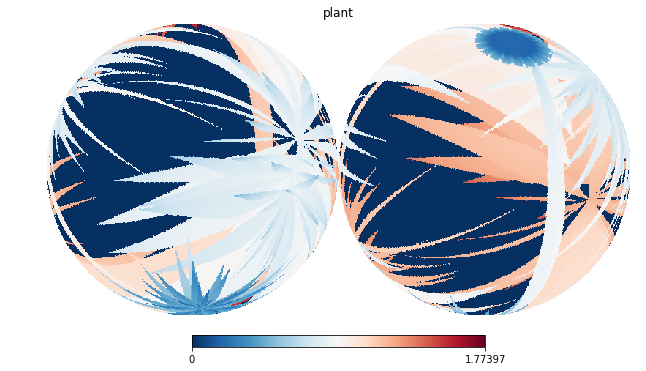

<Figure size 432x288 with 0 Axes>

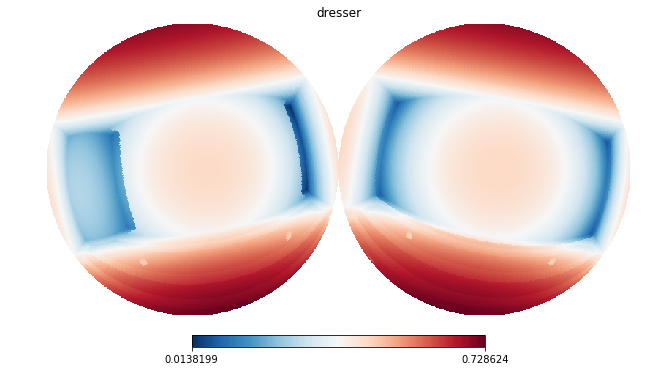

<Figure size 432x288 with 0 Axes>

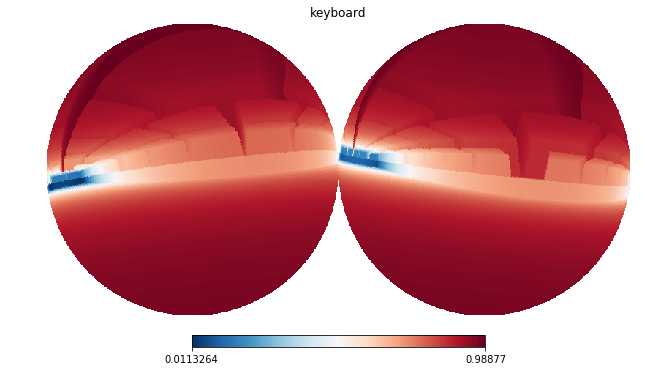

<Figure size 432x288 with 0 Axes>

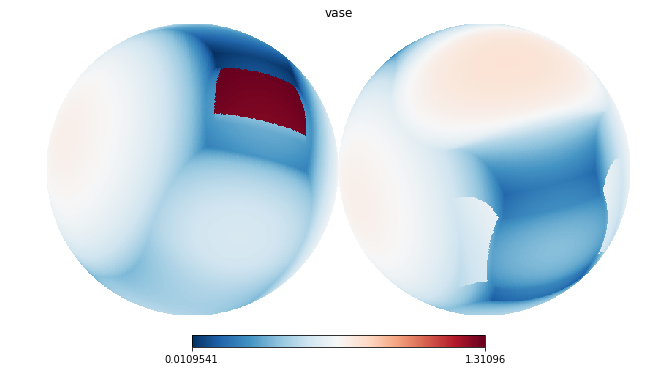

<Figure size 432x288 with 0 Axes>

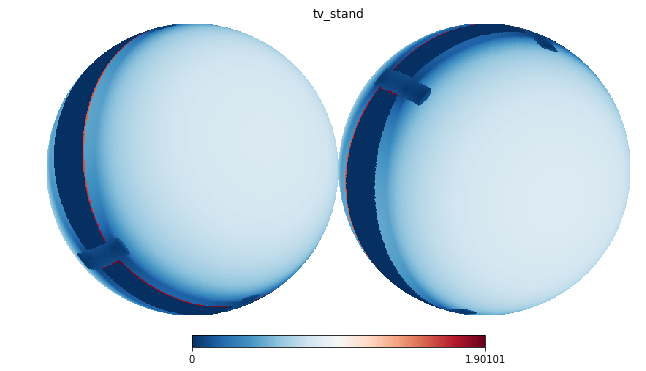

<Figure size 432x288 with 0 Axes>

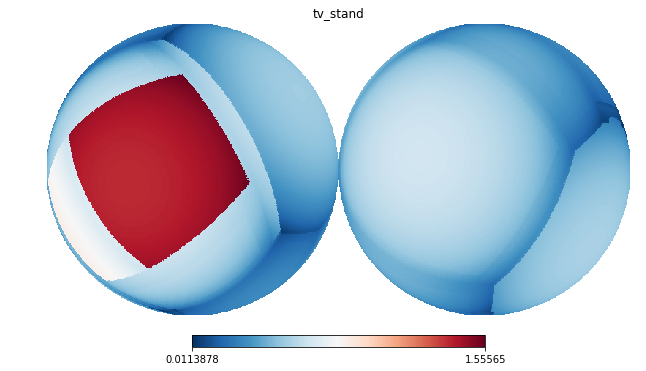

<Figure size 432x288 with 0 Axes>

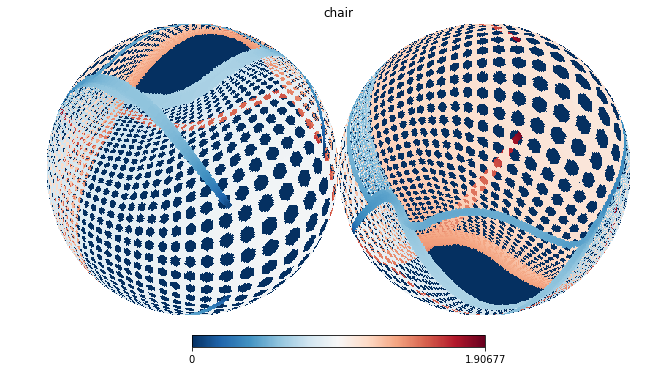

<Figure size 432x288 with 0 Axes>

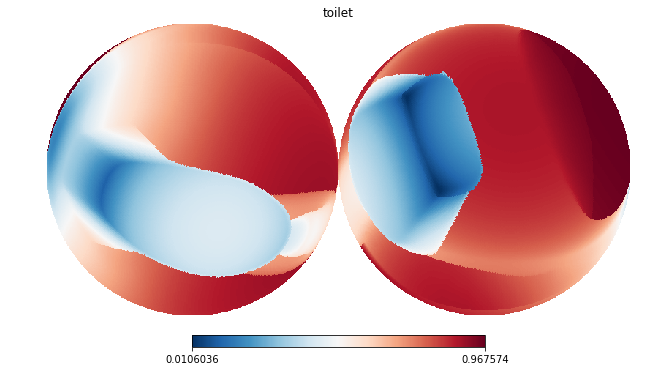

<Figure size 432x288 with 0 Axes>

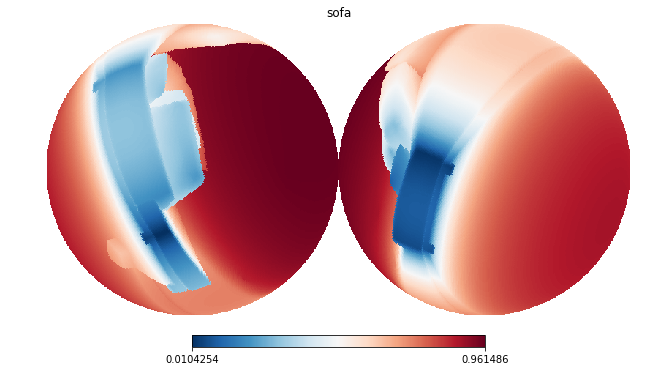

<Figure size 432x288 with 0 Axes>

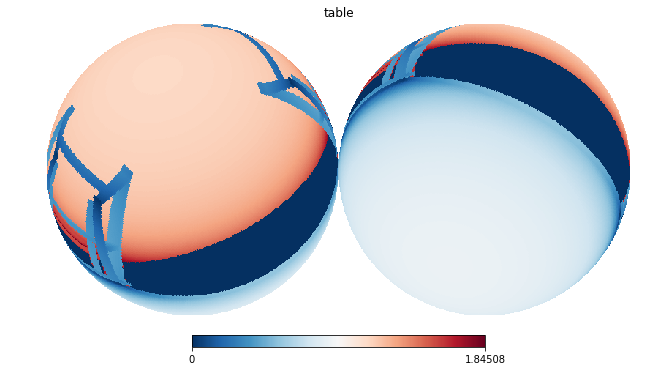

<Figure size 432x288 with 0 Axes>

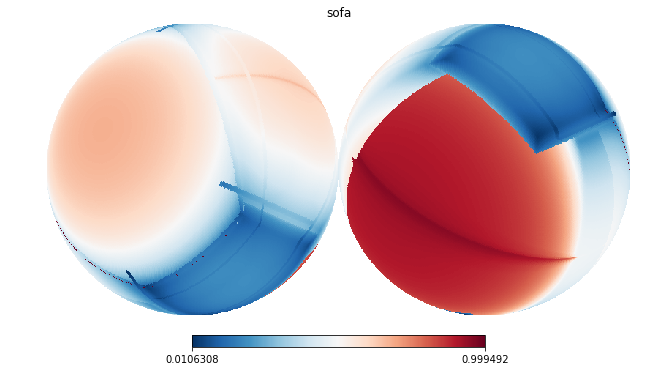

<Figure size 432x288 with 0 Axes>

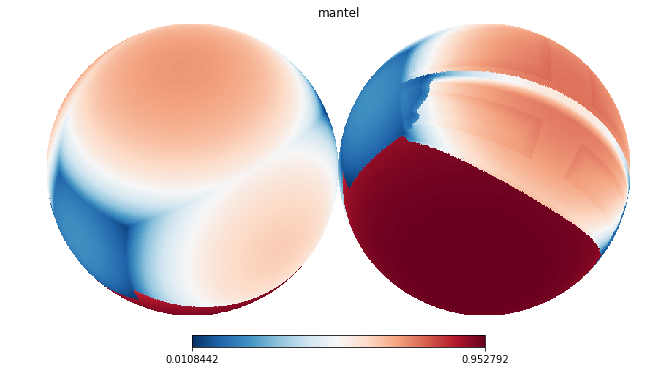

<Figure size 432x288 with 0 Axes>

In [46]:
import tensorflow as tf
from tqdm import tqdm

#dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
data_next = dataset.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = train_TFDataset.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm(range(steps)):
        data, label = sess.run(data_next)
        im1 = data[0,:,0]
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=train_TFDataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
        if i > 10:
            break
#     except tf.errors.OutOfRangeError:
#         print("Done") 

In [49]:
def transform(data, phi=None, theta=None):
    batch_size, npix, nfeat = data.shape
    if theta is None or phi is None:
        phi = np.random.rand() * 2 * np.pi
        theta = np.random.rand() * np.pi
    nside = hp.npix2nside(npix)

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(npix), nest=True) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[phi, theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    new_data = np.zeros(data.shape)
    for b in range(batch_size):
        for f in range(nfeat):
            new_data[b,:,f] = hp.get_interp_val(data[b,:,f], trot, prot, nest=True)

    return new_data

In [50]:
def transform_equator(data):
    return transform(data, 0, np.pi/2).astype(np.float32)

In [48]:
def transform_shift(data):
    """
    90° rotation around poles (natural Z-axis)
    """
    batch_size, npix, nfeat = data.shape
    new_data = data.copy()
    nside = hp.npix2nside(npix)
    theta, _ = hp.pix2ang(nside, range(npix))
    theta_u = np.unique(theta)
    for b in range(batch_size):
        for f in range(nfeat):
            new_data[b, :, f] = hp.reorder(data[b, :, f], n2r=True)
            for t in theta_u:
                ligne_ind = np.where(theta==t)[0]
                ligne_ind_roll = np.roll(ligne_ind, len(ligne_ind)//4)
                new_data[b,ligne_ind_roll,f] = new_data[b,ligne_ind,f]
            new_data[b, :, f] = hp.reorder(new_data[b, :, f], r2n = True)
    return new_data

In [51]:
def transform_inverse(data):
    """
    180° rotation around X-axis
    """
    batch_size, npix, nfeat = data.shape
    data_c = data.copy()
    new_data = data.copy()
    new_data[:] = -10
    nside = hp.npix2nside(npix)
    theta, _ = hp.pix2ang(nside, range(npix))
    theta_u = np.unique(theta)
    for b in range(batch_size):
        for f in range(nfeat):
            data_c[b, :, f] = hp.reorder(data[b, :, f], n2r=True)
            for i, (t, t_end) in enumerate(zip(theta_u, theta_u[::-1])):
                ligne_ind = np.where(theta==t)[0]
                ligne_ind_roll = np.where(theta==t_end)[0][::-1]
                if i > len(theta_u)/4 and i < len(theta_u)*3/4:
                    ligne_ind_roll = np.roll(ligne_ind_roll, (i+1)%2)
                new_data[b,ligne_ind_roll,f] = data_c[b,ligne_ind,f]
            new_data[b, :, f] = hp.reorder(new_data[b, :, f], r2n = True)
    return new_data

126
126
126
126
126
126


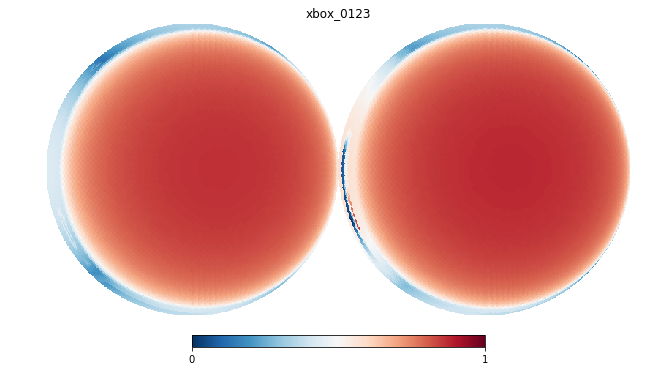

<Figure size 432x288 with 0 Axes>

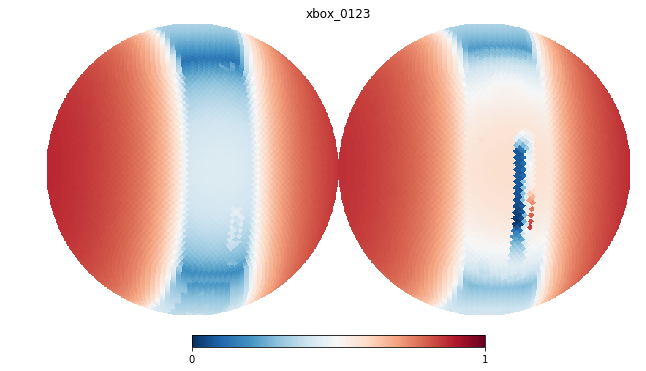

<Figure size 432x288 with 0 Axes>

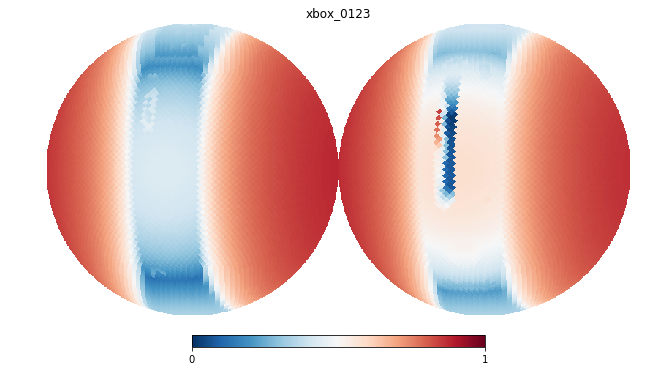

In [750]:
hp.orthview(im1[:,0], rot=(0,0,0), title=suffix, nest=True, cmap=cm, min=cmin, max=cmax)
plt.figure()
im2 = transform_shift(im1[np.newaxis,:,:])
hp.orthview(im2[0,:,0], rot=(0,0,0), title=suffix, nest=True, cmap=cm, min=cmin, max=cmax)
plt.figure()
im2 = transform_inverse(im2)
hp.orthview(im2[0,:,0], rot=(0,0,0), title=suffix, nest=True, cmap=cm, min=cmin, max=cmax)

In [130]:
from tqdm import tqdm
size = 1 # 32
steps = test_dataset.N // size + 1
data_iter = test_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
#     if np.std(im1)>2:
#         print(np.std(im1))
#     cmin = np.nanmin(im1)
#     cmax = np.nanmax(im1)
#     hp.orthview(im1, rot=(0,0,0), title=test_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
#     plt.figure()
#     if i > 10:
#         break

100%|██████████| 2469/2469 [00:38<00:00, 63.94it/s]


In [66]:
from tqdm import tqdm
size = 1 # 32
steps = test_rot_dataset.N // size + 1
data_iter = test_rot_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    if np.std(im1)>2:
        print(np.std(im1))
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=test_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
#     if i > 10:
#         break

100%|██████████| 7405/7405 [01:35<00:00, 77.18it/s]


In [70]:
from tqdm import tqdm
steps = train_dataset.N // 1 + 1
data_iter = train_dataset.iter(1, False)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    if np.std(im1)>2.5:
        print(np.std(im1))
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=train_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
#     if i > 10:
#         break

 67%|██████▋   | 6607/9844 [02:31<01:13, 43.75it/s]/mnt/scratch/students/gusset/DeepSphere/ModelNet40/load_MN40.py:415: RuntimeWarning: invalid value encountered in true_divide
  data = data / self.std
100%|██████████| 9844/9844 [03:47<00:00, 43.32it/s]



## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [19]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem)

number of class: 40 
number of elements: 9843


## 2 Classification using DeepSphere

In [17]:
EXP_NAME = 'MN40_{}_{}feat_{}aug_{}sides'.format(exp, nfeat, augmentation, Nside)
EXP_NAME = 'MN40_all_6feat_3aug_32sides'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [34]:
params = hyperparameters.get_params_shrec17_optim(train_TFDataset.N, EXP_NAME, Nside, nclass, 
                                                  nfeat_in=nfeat, architecture='CNN')
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
params["std"] = [0.001, 0.005, 0.0125, 0.05, 0.15, 0.5] # [0.00002, 0.0002, 0.001, 0.005, 0.0125, 0.05] #
#params["full"] = [True]*6
params["num_epochs"] = 40
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 1,209,507,840
Learning rate will start at 2.0e-02 and finish at 2.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 6 * 16 * 4 = 384
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    

In [567]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [77]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 185,200


In [569]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, 
                                                                                 test_dataset, 
                                                                                 use_tf_dataset=True, cache=True)

step 153 / 12303 (epoch 0.50 / 40):
  learning_rate = 2.00e-02, training accuracy = 62.50, training loss = 1.48e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 56.89 (1404 / 2468), f1 (weighted): 55.84, loss: 1.58e+00
  CPU time: 28s, wall time: 24s, perf_time_load: 0.096s, perf_time: 0.000s
step 306 / 12303 (epoch 0.99 / 40):
  learning_rate = 2.00e-02, training accuracy = 75.00, training loss = 1.08e+00
  validation accuracy: 68.92 (1701 / 2468), f1 (weighted): 68.30, loss: 1.13e+00
  CPU time: 54s, wall time: 46s, perf_time_load: 0.101s, perf_time: 0.000s
step 459 / 12303 (epoch 1.49 / 40):
  learning_rate = 2.00e-02, training accuracy = 71.88, training loss = 1.15e+00
  validation accuracy: 71.84 (1773 / 2468), f1 (weighted): 71.03, loss: 9.85e-01
  CPU time: 79s, wall time: 66s, perf_time_load: 0.106s, perf_time: 0.000s
step 612 / 12303 (epoch 1.99 / 40):
  learning_rate = 2.00e-02, training accuracy = 78.12, training loss = 7.35e-01
  validation accuracy: 72.65 (1793 / 2468), f1 (weighted): 71.31, loss: 9.78e-01
  CPU time: 104s, wall time: 87s, perf_time_load: 0.109s, perf_time: 0.000s
step 765 / 12303 (epoch 2.4

  validation accuracy: 84.32 (2081 / 2468), f1 (weighted): 84.71, loss: 5.64e-01
  CPU time: 777s, wall time: 646s, perf_time_load: 0.099s, perf_time: 0.000s
step 4896 / 12303 (epoch 15.92 / 40):
  learning_rate = 2.00e-02, training accuracy = 93.75, training loss = 9.95e-02
  validation accuracy: 85.49 (2110 / 2468), f1 (weighted): 85.99, loss: 5.43e-01
  CPU time: 802s, wall time: 667s, perf_time_load: 0.108s, perf_time: 0.000s
step 5049 / 12303 (epoch 16.41 / 40):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 2.95e-02
  validation accuracy: 85.62 (2113 / 2468), f1 (weighted): 85.74, loss: 5.58e-01
  CPU time: 827s, wall time: 687s, perf_time_load: 0.104s, perf_time: 0.000s
step 5202 / 12303 (epoch 16.91 / 40):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 3.43e-02
  validation accuracy: 84.89 (2095 / 2468), f1 (weighted): 84.96, loss: 5.82e-01
  CPU time: 852s, wall time: 708s, perf_time_load: 0.102s, perf_time: 0.000s
step 5355 / 

step 9333 / 12303 (epoch 30.34 / 40):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 6.25e-02
  validation accuracy: 84.97 (2097 / 2468), f1 (weighted): 85.14, loss: 5.81e-01
  CPU time: 1527s, wall time: 1268s, perf_time_load: 0.111s, perf_time: 0.000s
step 9486 / 12303 (epoch 30.84 / 40):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.13e-02
  validation accuracy: 84.12 (2076 / 2468), f1 (weighted): 84.93, loss: 6.36e-01
  CPU time: 1552s, wall time: 1289s, perf_time_load: 0.106s, perf_time: 0.000s
step 9639 / 12303 (epoch 31.34 / 40):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 9.65e-03
  validation accuracy: 85.94 (2121 / 2468), f1 (weighted): 86.13, loss: 5.79e-01
  CPU time: 1577s, wall time: 1310s, perf_time_load: 0.113s, perf_time: 0.000s
step 9792 / 12303 (epoch 31.83 / 40):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.52e-02
  validation accuracy: 86.22 (2128 / 2468), 

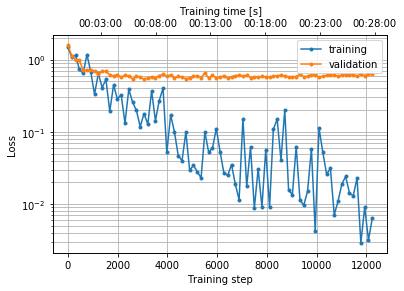

In [570]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [35]:
model.evaluate(train_rot_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_all_6feat_3aug_32sides/model-46139


('accuracy: 99.79 (29466 / 29529), f1 (weighted): 99.79, loss: 8.08e-03\nCPU time: 89s, wall time: 84s',
 99.78665041145992,
 99.78650466670655,
 0.008075959776302705,
 None)

In [572]:
model.evaluate(train_rot_tr_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 67.93 (20059 / 29529), f1 (weighted): 66.99, loss: 1.24e+00\nCPU time: 83s, wall time: 80s',
 67.92983169088015,
 66.99266084841646,
 1.2357250310059482,
 None)

In [573]:
model.evaluate(train_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 99.40 (9784 / 9843), f1 (weighted): 99.39, loss: 2.25e-02\nCPU time: 19s, wall time: 18s',
 99.40058925124454,
 99.39352845082617,
 0.022528559440883344,
 None)

In [574]:
model.evaluate(train_tr_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 92.65 (27358 / 29529), f1 (weighted): 92.55, loss: 2.56e-01\nCPU time: 83s, wall time: 79s',
 92.64790544888076,
 92.55321139217475,
 0.25636020169828266,
 None)

In [575]:
model.evaluate(train_Z_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 76.34 (22541 / 29529), f1 (weighted): 78.01, loss: 1.08e+00\nCPU time: 83s, wall time: 79s',
 76.3351281790782,
 78.0149513350652,
 1.0757460325634391,
 None)

## test network

In [542]:
test_dataset.reduce_dataset(None)

In [576]:
model.evaluate(test_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 84.68 (2090 / 2468), f1 (weighted): 84.73, loss: 6.34e-01\nCPU time: 5s, wall time: 5s',
 84.6839546191248,
 84.73128089010686,
 0.6344916466865055,
 None)

In [544]:
test_dataset.set_transform(transform_shift)
print(model.evaluate(test_dataset, None, cache=True))
test_dataset.set_transform(None)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-3075
('accuracy: 86.22 (2128 / 2468), f1 (weighted): 85.90, loss: 5.02e-01\nCPU time: 37s, wall time: 37s', 86.22366288492707, 85.8978845373998, 0.501952913425247, None)


In [149]:
test_rot_dataset.reduce_dataset(1500)

In [577]:
model.evaluate(test_rot_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 65.01 (4813 / 7404), f1 (weighted): 63.87, loss: 1.45e+00\nCPU time: 21s, wall time: 20s',
 65.00540248514316,
 63.865678964873354,
 1.4503517230375917,
 None)

In [578]:
model.evaluate(test_rot_tr_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 60.79 (4501 / 7404), f1 (weighted): 59.78, loss: 1.68e+00\nCPU time: 21s, wall time: 20s',
 60.7914640734738,
 59.778959603520775,
 1.6796898821571078,
 None)

In [579]:
model.evaluate(test_tr_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 81.62 (6043 / 7404), f1 (weighted): 81.73, loss: 7.82e-01\nCPU time: 21s, wall time: 20s',
 81.61804430037817,
 81.72619372000943,
 0.7816841015325551,
 None)

In [580]:
model.evaluate(test_Z_dataset, None, cache=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_2feat_1aug_32sides/model-12303


('accuracy: 46.92 (3474 / 7404), f1 (weighted): 50.99, loss: 3.01e+00\nCPU time: 21s, wall time: 20s',
 46.92058346839546,
 50.989503508933524,
 3.008065980473188,
 None)

exploration of results

In [36]:
predictions, loss = model.predict(test_dataset, None, cache=True)
print(loss)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_all_6feat_3aug_32sides/model-46139
0.6573352076851339


In [37]:
predictions_rot, loss = model.predict(test_rot_dataset, None, cache=True)
print(loss)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_all_6feat_3aug_32sides/model-46139
0.6052417161849064


In [38]:
labels_test = test_dataset.get_labels()

In [39]:
from collections import Counter
from sklearn.metrics import accuracy_score
# hist = Counter(predictions)
hist = Counter(labels_test)
tot = 0
accuracy_class = np.empty((40,))
for _class, nb in sorted(hist.items()):
    if _class == 15:
        for pred in predictions[tot:tot+nb]:
            print(test_dataset.classes[int(pred)])
    accuracy_class[int(_class)] = accuracy_score(labels_test[tot:tot+nb], predictions[tot:tot+nb])*100
    tot += nb

plant
table
flower_pot
vase
flower_pot
bowl
plant
plant
flower_pot
vase
vase
plant
vase
vase
plant
plant
plant
flower_pot
plant
plant


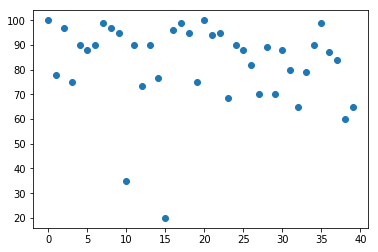

In [40]:
plt.plot(accuracy_class, 'o')

In [41]:
test_dataset.classes[np.argmin(accuracy_class)]

'flower_pot'

In [42]:
labels_3_test = test_rot_dataset.get_labels()

In [43]:
from collections import Counter
from sklearn.metrics import accuracy_score
# hist = Counter(predictions)
hist = Counter(labels_3_test)
tot = 0
accuracy_class = np.empty((40,))
for _class, nb in sorted(hist.items()):
    accuracy_class[int(_class)] = accuracy_score(labels_3_test[tot:tot+nb], predictions_rot[tot:tot+nb])*100
    tot += nb

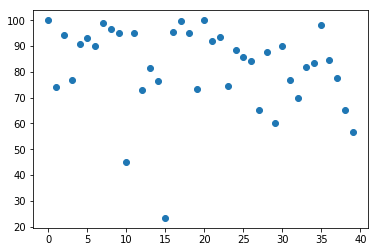

In [44]:
plt.plot(accuracy_class, 'o')

In [45]:
files = test_dataset.files
files = [file for file in files if 'desk' in file]
files = files[:64]
batch_1 = np.vstack(test_dataset.get_npy_file(files))
batch_1_rot = np.vstack(test_rot_dataset.get_npy_file(files))

In [52]:
test_dataset.set_transform(transform_shift)
batch_1_shift = np.vstack(test_dataset.get_npy_file(files))
test_dataset.set_transform(None)

In [53]:
probs = model.probs(batch_1, 40)
probs_shift = model.probs(batch_1_shift, 40)
probs_rot = model.probs(batch_1_rot, 40)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_all_6feat_3aug_32sides/model-46139
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_all_6feat_3aug_32sides/model-46139
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_all_6feat_3aug_32sides/model-46139


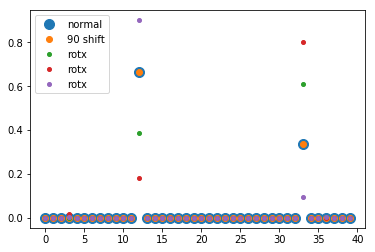

In [54]:
obj = 17
plt.plot(probs[obj,:], 'o', markersize=10, label='normal')
plt.plot(probs_shift[obj,:], 'o', label='90 shift')
plt.plot(probs_rot[3*obj:3*obj+3, :].T, 'o', markersize=4, label = 'rotx')
plt.legend()

In [55]:
plop = np.argmax(probs[obj,:])
test_dataset.classes[plop]

'desk'

In [56]:
plop = np.argmax(probs_rot[3*obj:3*obj+3, :].mean(axis=0))
test_dataset.classes[plop]

'table'

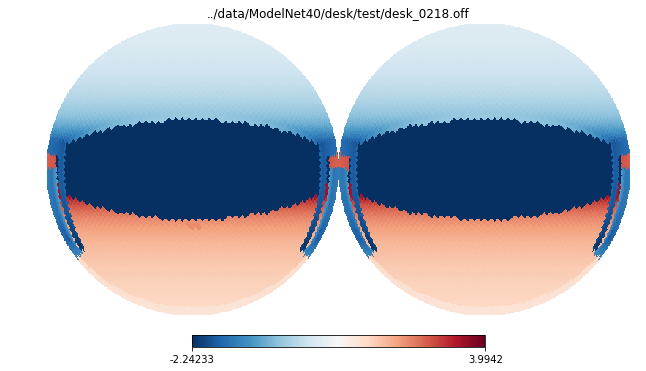

In [57]:
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(batch_1[:,:,0])
cmax = np.max(batch_1[:,:,0])
hp.orthview(batch_1[obj,:,0], rot=(0,0,0), title=files[obj], nest=True, cmap=cm, min=cmin, max=cmax)

<Figure size 432x288 with 0 Axes>

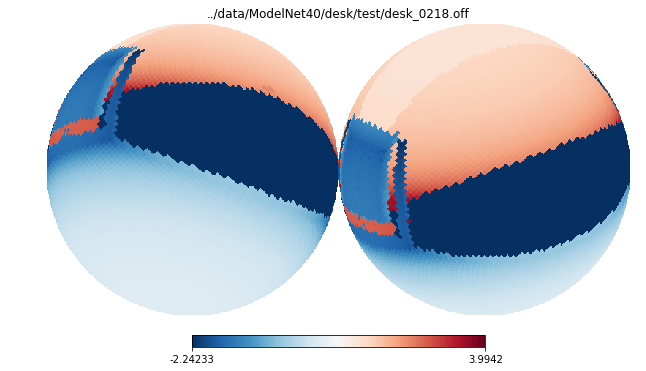

<Figure size 432x288 with 0 Axes>

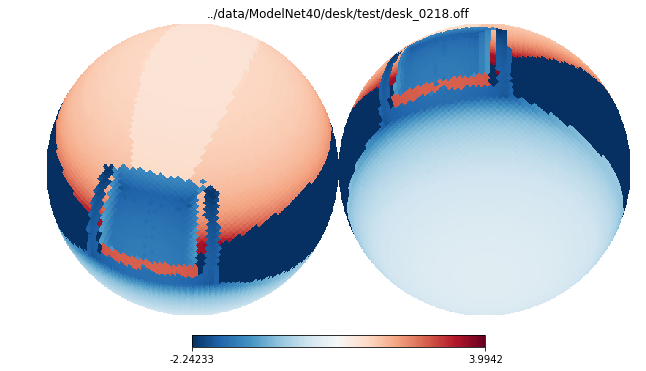

<Figure size 432x288 with 0 Axes>

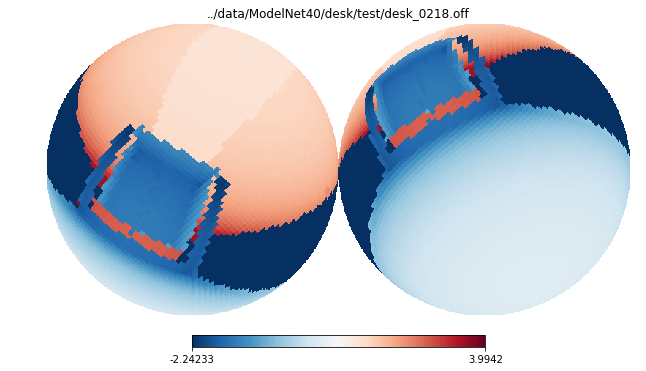

In [58]:
for i in range(3):
    plt.figure()
    hp.orthview(batch_1_rot[3*obj+i,:,0], rot=(0,0,0), title=files[obj], nest=True, cmap=cm, min=cmin, max=cmax)

Why not working?

In [241]:
def _print_histogram(nclass, labels_train, labels_min=None, ylim=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,ylim)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

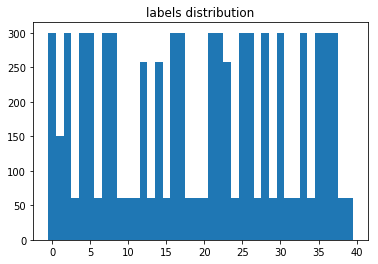

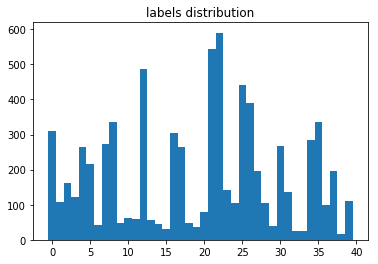

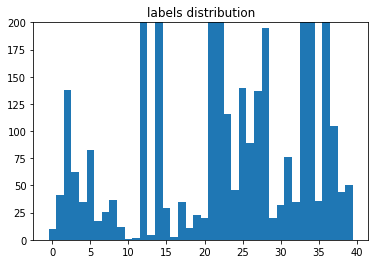

In [583]:
_print_histogram(40, labels_test)
_print_histogram(40, predictions)
_print_histogram(40, labels_test, predictions, ylim=200)

In [109]:
from collections import Counter
tot = predictions.shape[0]
hist = Counter(predictions)
hist.subtract(Counter(labels_test))
p_tot = 0
for _class, nb in hist.most_common():
    percent = 100*nb/Counter(labels_test)[_class]
    p_tot += percent
    print("{:2.0f}".format(_class), test_rot_dataset.classes[int(_class)], "{:.2f}".format(percent))

21 mantel 26.00
12 desk 29.07
 2 bed 11.00
 3 bench 55.00
 8 chair 9.00
10 cup 40.00
27 radio 35.00
34 tent 30.00
 5 bottle 5.00
35 toilet 5.00
31 stairs 20.00
38 wardrobe 15.00
16 glass_box 3.00
39 xbox 15.00
13 door 10.00
26 plant 2.00
19 lamp 5.00
20 laptop 5.00
22 monitor 1.00
 0 airplane 0.00
 4 bookshelf 0.00
32 stool 0.00
18 keyboard 0.00
 1 bathtub -2.00
30 sofa -1.00
11 curtain -5.00
17 guitar -1.00
 9 cone -10.00
24 person -10.00
23 night_stand -3.49
 6 bowl -20.00
15 flower_pot -20.00
 7 car -4.00
29 sink -30.00
25 piano -9.00
14 dresser -10.47
37 vase -12.00
36 tv_stand -17.00
28 range_hood -27.00
33 table -30.00


In [248]:
from sklearn.metrics import confusion_matrix

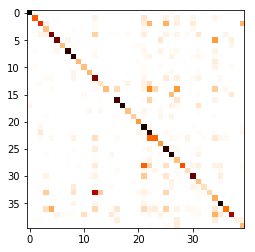

In [585]:
plt.imshow(confusion_matrix(labels_test, predictions, range(40)), cmap = plt.cm.gist_heat_r)